In [1]:
# Import Libraries and Initial Setup
import os
import numpy as np
import pydicom
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm

# Enable memory growth for GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("Using GPU:", physical_devices[0])
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Memory growth enabled")
    except:
        print("Invalid GPU device or cannot modify virtual devices once initialized")
else:
    print("No GPU found, using CPU")

# Custom parameters
IMAGE_SIZE = 128  # Resize images to 128x128
BATCH_SIZE = 16   # Reduced batch size to avoid memory issues
EPOCHS = 1      # Number of epochs
WINDOW_LEVEL = 40  # Brain window level
WINDOW_WIDTH = 120  # Brain window width
VALIDATION_SPLIT = 0.2

# Define paths (no sample limit)
NORMAL_DIR = r"C:\Users\Atharva Badgujar\OneDrive\Desktop\Hemorrhage new\LSTM model\Normal"  # Update this to your actual normal directory
HEMORRHAGE_DIR = r"C:\Users\Atharva Badgujar\OneDrive\Desktop\Hemorrhage new\LSTM model\HEMORRHAGES CT AI\Hemorrhage"  # Update this to your actual hemorrhage directory
OUTPUT_DIR = r"C:\Users\Atharva Badgujar\OneDrive\Desktop\Hemorrhage new\UNET"  # Output directory for models only
# Create output directory structure (only for models)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'models'), exist_ok=True)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Memory growth enabled


In [2]:
# Utility Functions
def window_ct(image, window_level=40, window_width=120):
    window_min = window_level - window_width / 2
    window_max = window_level + window_width / 2
    
    windowed = (image - window_min) * (255 / (window_max - window_min))
    windowed[windowed < 0] = 0
    windowed[windowed > 255] = 255
    
    return windowed.astype(np.uint8)

def load_dicom(path, target_size=(128, 128)):
    try:
        # Load DICOM file
        dicom = pydicom.dcmread(path)
        
        # Convert to numpy array
        img = dicom.pixel_array.astype(np.float32)
        
        # Apply windowing
        img = window_ct(img, WINDOW_LEVEL, WINDOW_WIDTH)
        
        # Resize
        img = cv2.resize(img, target_size)
        
        # Normalize to [0, 1]
        img = img / 255.0
        
        # Add channel dimension if needed
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=-1)
            
        return img
    
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

In [3]:
# Get DICOM Paths with Reduced Debugging Output
def get_dicom_paths(base_dir):
    dicom_paths = []
    print(f"Scanning directory: {base_dir}")
    
    if not os.path.exists(base_dir):
        print(f"Error: Directory {base_dir} does not exist!")
        return dicom_paths
    
    patient_count = 0
    date_count = 0
    file_count = 0
    
    for patient_dir in os.listdir(base_dir):
        patient_path = os.path.join(base_dir, patient_dir)
        if not os.path.isdir(patient_path):
            continue
        patient_count += 1
        
        for date_dir in os.listdir(patient_path):
            date_path = os.path.join(patient_path, date_dir)
            if not os.path.isdir(date_path):
                continue
            date_count += 1
            
            for file in os.listdir(date_path):
                if file.lower().endswith(('.dcm', '.DCM', '.dic', '.DIC')):
                    full_path = os.path.join(date_path, file)
                    dicom_paths.append(full_path)
                    file_count += 1
    
    print(f"Found {patient_count} patient folders, {date_count} date folders, {file_count} DICOM files")
    return dicom_paths

print("Getting DICOM paths...")
normal_paths = get_dicom_paths(NORMAL_DIR)
hemorrhage_paths = get_dicom_paths(HEMORRHAGE_DIR)

print(f"Found {len(normal_paths)} normal DICOM files.")
print(f"Found {len(hemorrhage_paths)} hemorrhage DICOM files.")

if len(normal_paths) == 0:
    print("Warning: No normal DICOM files found. Check if NORMAL_DIR is correct and contains .dcm files.")
if len(hemorrhage_paths) == 0:
    print("Warning: No hemorrhage DICOM files found. Check if HEMORRHAGE_DIR is correct and contains .dcm files.")

Getting DICOM paths...
Scanning directory: C:\Users\Atharva Badgujar\OneDrive\Desktop\Hemorrhage new\LSTM model\Normal
Found 34 patient folders, 45 date folders, 35539 DICOM files
Scanning directory: C:\Users\Atharva Badgujar\OneDrive\Desktop\Hemorrhage new\LSTM model\HEMORRHAGES CT AI\Hemorrhage
Found 52 patient folders, 74 date folders, 35952 DICOM files
Found 35539 normal DICOM files.
Found 35952 hemorrhage DICOM files.


In [4]:
# Get DICOM Paths with Reduced Debugging Output
def get_dicom_paths(base_dir):
    dicom_paths = []
    print(f"Scanning directory: {base_dir}")
    
    if not os.path.exists(base_dir):
        print(f"Error: Directory {base_dir} does not exist!")
        return dicom_paths
    
    patient_count = 0
    date_count = 0
    file_count = 0
    
    for patient_dir in os.listdir(base_dir):
        patient_path = os.path.join(base_dir, patient_dir)
        if not os.path.isdir(patient_path):
            continue
        patient_count += 1
        
        for date_dir in os.listdir(patient_path):
            date_path = os.path.join(patient_path, date_dir)
            if not os.path.isdir(date_path):
                continue
            date_count += 1
            
            for file in os.listdir(date_path):
                if file.lower().endswith(('.dcm', '.DCM', '.dic', '.DIC')):
                    full_path = os.path.join(date_path, file)
                    dicom_paths.append(full_path)
                    file_count += 1
    
    print(f"Found {patient_count} patient folders, {date_count} date folders, {file_count} DICOM files")
    return dicom_paths

print("Getting DICOM paths...")
normal_paths = get_dicom_paths(NORMAL_DIR)
hemorrhage_paths = get_dicom_paths(HEMORRHAGE_DIR)

print(f"Found {len(normal_paths)} normal DICOM files.")
print(f"Found {len(hemorrhage_paths)} hemorrhage DICOM files.")

if len(normal_paths) == 0:
    print("Warning: No normal DICOM files found. Check if NORMAL_DIR is correct and contains .dcm files.")
if len(hemorrhage_paths) == 0:
    print("Warning: No hemorrhage DICOM files found. Check if HEMORRHAGE_DIR is correct and contains .dcm files.")

Getting DICOM paths...
Scanning directory: C:\Users\Atharva Badgujar\OneDrive\Desktop\Hemorrhage new\LSTM model\Normal
Found 34 patient folders, 45 date folders, 35539 DICOM files
Scanning directory: C:\Users\Atharva Badgujar\OneDrive\Desktop\Hemorrhage new\LSTM model\HEMORRHAGES CT AI\Hemorrhage
Found 52 patient folders, 74 date folders, 35952 DICOM files
Found 35539 normal DICOM files.
Found 35952 hemorrhage DICOM files.


In [5]:
# Prepare Data (Split and Load)
if len(normal_paths) == 0 and len(hemorrhage_paths) == 0:
    raise ValueError("No DICOM files found in either directory. Please check the paths and dataset.")

if len(normal_paths) == 0:
    print("Warning: No normal DICOM files found. Proceeding with only hemorrhage data.")
    train_paths = hemorrhage_paths
    val_paths = []
    train_labels = [1] * len(hemorrhage_paths)  # All labels are hemorrhage (1)
    val_labels = []
    num_train_samples = len(train_paths)
    num_val_samples = 0
elif len(hemorrhage_paths) == 0:
    print("Warning: No hemorrhage DICOM files found. Proceeding with only normal data.")
    train_paths = normal_paths
    val_paths = []
    train_labels = [0] * len(normal_paths)  # All labels are normal (0)
    val_labels = []
    num_train_samples = len(train_paths)
    num_val_samples = 0
else:
    # Split data into train and validation sets
    normal_train, normal_val = train_test_split(normal_paths, test_size=VALIDATION_SPLIT, random_state=42)
    hemorrhage_train, hemorrhage_val = train_test_split(hemorrhage_paths, test_size=VALIDATION_SPLIT, random_state=42)

    train_paths = normal_train + hemorrhage_train
    val_paths = normal_val + hemorrhage_val
    train_labels = [0] * len(normal_train) + [1] * len(hemorrhage_train)
    val_labels = [0] * len(normal_val) + [1] * len(hemorrhage_val)

    # Shuffle training data
    train_indices = np.random.permutation(len(train_paths))
    train_paths = [train_paths[i] for i in train_indices]
    train_labels = [train_labels[i] for i in train_indices]

    num_train_samples = len(train_paths)
    num_val_samples = len(val_paths)

print(f"Training samples: {num_train_samples}")
print(f"Validation samples: {num_val_samples}")

Training samples: 57192
Validation samples: 14299


In [6]:
# Define U-Net Model
def unet_model(input_size=(128, 128, 1), learning_rate=1e-5, decay_rate=1e-7):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Middle
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5)
    )
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6)
    )
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7)
    )
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8)
    )
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Custom jaccard loss
    def jaccard_loss(y_true, y_pred):
        intersection = K.sum(y_true * y_pred)
        union = K.sum(y_true) + K.sum(y_pred) - intersection
        return 1 - intersection / (union + K.epsilon())
    
    model.compile(
        optimizer=Adam(learning_rate=1e-5, decay=1e-7),
        loss='binary_crossentropy',
        metrics=['accuracy', jaccard_loss]
    )
    
    return model

print("Creating U-Net model...")
model = unet_model(input_size=(IMAGE_SIZE, IMAGE_SIZE, 1))

Creating U-Net model...


In [3]:
!pip install python-gdcm --no-deps
!pip install pyjpegls --no-deps
!pip install pylibjpeg-libjpeg --no-deps

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# Train Model (Only Save Models)
if 'num_train_samples' not in globals():
    raise NameError("num_train_samples is not defined. Ensure Cell 4 runs successfully.")

history = {
    'loss': [],
    'accuracy': [],
    'jaccard_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_jaccard_loss': []
}

num_train_batches = (num_train_samples + BATCH_SIZE - 1) // BATCH_SIZE
num_val_batches = (num_val_samples + BATCH_SIZE - 1) // BATCH_SIZE if num_val_samples > 0 else 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    start_time = time.time()
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_jaccard = 0
    
    for batch_idx in tqdm(range(num_train_batches), desc="Training"):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = min(start_idx + BATCH_SIZE, num_train_samples)
        
        batch_paths = train_paths[start_idx:end_idx]
        batch_labels = train_labels[start_idx:end_idx]
        
        batch_images = []
        valid_indices = []
        
        for i, path in enumerate(batch_paths):
            img = load_dicom(path, (IMAGE_SIZE, IMAGE_SIZE))
            if img is not None:
                batch_images.append(img)
                valid_indices.append(i)
        
        batch_labels = [batch_labels[i] for i in valid_indices]
        
        if len(batch_images) == 0:
            continue
            
        images = np.array(batch_images)
        labels = np.array(batch_labels)
        
        masks = np.zeros_like(images)
        for i, label in enumerate(labels):
            if label == 1:
                masks[i] = (images[i] > 0.7).astype(np.float32)
        
        batch_history = model.train_on_batch(images, masks)
        
        epoch_loss += batch_history[0]
        epoch_acc += batch_history[1]
        epoch_jaccard += batch_history[2]
    
    epoch_loss /= num_train_batches
    epoch_acc /= num_train_batches
    epoch_jaccard /= num_train_batches
    
    val_loss = 0
    val_acc = 0
    val_jaccard = 0
    
    if num_val_samples > 0:
        for batch_idx in tqdm(range(num_val_batches), desc="Validation"):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = min(start_idx + BATCH_SIZE, num_val_samples)
            
            batch_paths = val_paths[start_idx:end_idx]
            batch_labels = val_labels[start_idx:end_idx]
            
            batch_images = []
            valid_indices = []
            
            for i, path in enumerate(batch_paths):
                img = load_dicom(path, (IMAGE_SIZE, IMAGE_SIZE))
                if img is not None:
                    batch_images.append(img)
                    valid_indices.append(i)
            
            batch_labels = [batch_labels[i] for i in valid_indices]
            
            if len(batch_images) == 0:
                continue
                
            images = np.array(batch_images)
            labels = np.array(batch_labels)
            
            masks = np.zeros_like(images)
            for i, label in enumerate(labels):
                if label == 1:
                    masks[i] = (images[i] > 0.7).astype(np.float32)
            
            batch_val_history = model.test_on_batch(images, masks)
            
            val_loss += batch_val_history[0]
            val_acc += batch_val_history[1]
            val_jaccard += batch_val_history[2]
        
        val_loss /= num_val_batches
        val_acc /= num_val_batches
        val_jaccard /= num_val_batches
    
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)
    history['jaccard_loss'].append(epoch_jaccard)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['val_jaccard_loss'].append(val_jaccard)
    
    print(f"loss: {epoch_loss:.4f} - accuracy: {epoch_acc:.4f} - jaccard_loss: {epoch_jaccard:.4f} - "
          f"val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f} - val_jaccard_loss: {val_jaccard:.4f}")
    print(f"Time: {time.time() - start_time:.2f}s")
    
    model.save(os.path.join(OUTPUT_DIR, 'models', f'unet_epoch_{epoch+1}.h5'))

Epoch 1/1


Training:  86%|██████████████████████████████████████████████████████████▍         | 3075/3575 [40:28<06:09,  1.35it/s]

Error processing C:\Users\Atharva Badgujar\OneDrive\Desktop\Hemorrhage new\LSTM model\Normal\JAYASHRI_JAGTAP___54Y_F 3913072\2024-08-06 161531_001\IMG-0005-00001.dcm: Unable to convert the pixel data: one of Pixel Data, Float Pixel Data or Double Float Pixel Data must be present in the dataset


Validation:  16%|██████████▌                                                         | 139/894 [01:27<07:39,  1.64it/s]

Error processing C:\Users\Atharva Badgujar\OneDrive\Desktop\Hemorrhage new\LSTM model\Normal\JAYASHRI_JAGTAP___54Y_F 3913072\2024-08-06 161531\IMG-0005-00001.dcm: Unable to convert the pixel data: one of Pixel Data, Float Pixel Data or Double Float Pixel Data must be present in the dataset


Validation: 100%|████████████████████████████████████████████████████████████████████| 894/894 [12:07<00:00,  1.23it/s]


loss: 0.2314 - accuracy: 0.8679 - jaccard_loss: 0.6682 - val_loss: 0.2261 - val_accuracy: 0.8910 - val_jaccard_loss: 0.7641
Time: 3578.23s


In [9]:
# Save Final Model
model.save(os.path.join(OUTPUT_DIR, 'models', 'unet_final.h5'))
print("Final model saved.")
print("Done!")

Final model saved.
Done!


In [3]:
import os
import numpy as np
import pydicom
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# === CONFIG ===
IMAGE_SIZE = 128
BATCH_SIZE = 32
SEG_MODEL_PATH = 'models/unet_epoch_1.h5'
HEMORRHAGE_PATH = r"C:\Users\Atharva Badgujar\OneDrive\Desktop\Hemorrhage new\LSTM model\HEMORRHAGES CT AI\Hemorrhage"
NORMAL_PATH = r"C:\Users\Atharva Badgujar\OneDrive\Desktop\Hemorrhage new\LSTM model\Normal"

# === LOAD TRAINED UNET ===
seg_model = load_model(SEG_MODEL_PATH, compile=False)

# === LOAD DICOM IMAGE ===
def load_dicom_image(path):
    dcm = pydicom.dcmread(path)
    img = dcm.pixel_array.astype(np.float32)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)
    return img

# === APPLY SEGMENTATION MASK ===
def generate_masked_input(image):
    input_img = np.expand_dims(image, axis=(0, -1))  # (1, 128, 128, 1)
    predicted_mask = seg_model.predict(input_img, verbose=0)[0, :, :, 0]
    masked_image = image * predicted_mask
    return masked_image

# === FIND FIRST DICOM FILE IN FOLDER ===
def get_first_dicom_path(folder):
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".dcm"):
                return os.path.join(root, file)
    return None

# === LOAD DATASET FROM SEPARATE FOLDERS ===
def load_dataset_from_path(class_path, label):
    images = []
    labels = []
    for patient in tqdm(os.listdir(class_path), desc=f"Loading label {label}"):
        patient_folder = os.path.join(class_path, patient)
        dcm_path = get_first_dicom_path(patient_folder)
        if dcm_path:
            try:
                img = load_dicom_image(dcm_path)
                masked_img = generate_masked_input(img)
                images.append(masked_img)
                labels.append(label)
            except Exception as e:
                print(f"Error reading {dcm_path}: {e}")
                continue
    return images, labels

# === LOAD ALL DATA ===
X_h, y_h = load_dataset_from_path(HEMORRHAGE_PATH, 1)
X_n, y_n = load_dataset_from_path(NORMAL_PATH, 0)

X = np.array(X_h + X_n).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
y = np.array(y_h + y_n)

# === SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === CLASSIFIER MODEL ===
def build_classifier(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

clf_model = build_classifier()
clf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === TRAIN ===
clf_model.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# === EVALUATE ===
preds = clf_model.predict(X_test) > 0.5
print(classification_report(y_test, preds.astype(int)))

# === SAVE CLASSIFIER MODEL ===
clf_model.save("classifier_model.h5")
print("Classifier model saved as classifier_model.h5")


Loading label 0: 100%|█████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.46it/s]

Epoch 1/100


3/3 [==============================] - 1s 159ms/step - loss: 0.6919 - accuracy: 0.5441 - val_loss: 0.6973 - val_accuracy: 0.3889
Epoch 2/100
3/3 [==============================] - 0s 51ms/step - loss: 0.6857 - accuracy: 0.6618 - val_loss: 0.7042 - val_accuracy: 0.3889
Epoch 3/100
3/3 [==============================] - 0s 44ms/step - loss: 0.6773 - accuracy: 0.6618 - val_loss: 0.7226 - val_accuracy: 0.3889
Epoch 4/100
3/3 [==============================] - 0s 28ms/step - loss: 0.6640 - accuracy: 0.6618 - val_loss: 0.7624 - val_accuracy: 0.3889
Epoch 5/100
3/3 [==============================] - 0s 43ms/step - loss: 0.6566 - accuracy: 0.6618 - val_loss: 0.7918 - val_accuracy: 0.3889
Epoch 6/100
3/3 [==============================] - 0s 40ms/step - loss: 0.6473 - accuracy: 0.6618 - val_loss: 0.7708 - val_accuracy: 0.3889
Epoch 7/100
3/3 [==============================] - 0s 42ms/step - loss: 0.6460 - accuracy: 0.6618 - val_loss: 0.7675 - val_accuracy: 0.3889
Epoch 8/100
3/3 [==============

C:\Users\Atharva Badgujar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Atharva Badgujar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Atharva Badgujar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [ ]:
import os
import pydicom
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from tensorflow.keras.models import load_model

# === CONFIG ===
IMAGE_SIZE = 128
TEST_DATASET_PATH = 'path_to_test_folder'  # Folder containing 'hemorrhagic' and 'normal'
SEG_MODEL_PATH = 'your_trained_unet.h5'
CLF_MODEL_PATH = 'classifier_model.h5'

# === LOAD MODELS ===
seg_model = load_model(SEG_MODEL_PATH, compile=False)
clf_model = load_model(CLF_MODEL_PATH, compile=False)

# === IMAGE PROCESSING ===
def load_dicom_image(dcm_path):
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array.astype(np.float32)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)
    return img

def generate_mask(img):
    input_img = np.expand_dims(img, axis=(0, -1))
    pred_mask = seg_model.predict(input_img, verbose=0)[0, :, :, 0]
    return (pred_mask > 0.5).astype(np.float32)

def apply_mask(img, mask):
    return img * mask

def predict_label(masked_img):
    input_img = np.expand_dims(masked_img, axis=(0, -1))
    pred = clf_model.predict(input_img, verbose=0)[0][0]
    return "Hemorrhage" if pred >= 0.5 else "Normal", float(pred)

def get_first_dicom(folder_path):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".dcm"):
                return os.path.join(root, file)
    return None

# === RUN PREDICTION ===
def predict_on_dataset(base_dir):
    results = []

    for true_label in ["hemorrhagic", "normal"]:
        label_dir = os.path.join(base_dir, true_label)
        if not os.path.isdir(label_dir):
            print(f"Skipping missing folder: {label_dir}")
            continue

        for patient_id in tqdm(os.listdir(label_dir), desc=f"Processing {true_label}"):
            patient_folder = os.path.join(label_dir, patient_id)
            if not os.path.isdir(patient_folder):
                continue

            dcm_path = get_first_dicom(patient_folder)
            if not dcm_path:
                continue

            try:
                img = load_dicom_image(dcm_path)
                mask = generate_mask(img)
                masked_img = apply_mask(img, mask)
                pred_label, confidence = predict_label(masked_img)

                results.append({
                    "PatientID": patient_id,
                    "TrueLabel": true_label,
                    "PredictedLabel": pred_label,
                    "Confidence": confidence
                })

            except Exception as e:
                print(f"Error processing {patient_id}: {e}")

    df = pd.DataFrame(results)
    df.to_csv("segmentation_classification_results.csv", index=False)
    print("✅ Saved results to segmentation_classification_results.csv")

# === RUN ===
predict_on_dataset(TEST_DATASET_PATH)


In [5]:
import matplotlib.pyplot as plt

def visualize_prediction(img, mask, masked_img, pred, label):
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(img, cmap='gray'); axs[0].set_title('Original')
    axs[1].imshow(mask, cmap='gray'); axs[1].set_title('Predicted Mask')
    axs[2].imshow(masked_img, cmap='gray'); axs[2].set_title(f'Masked - Pred: {label} ({pred:.2f})')
    for ax in axs: ax.axis('off')
    plt.show()


1/1 [==============================] - 0s 31ms/step


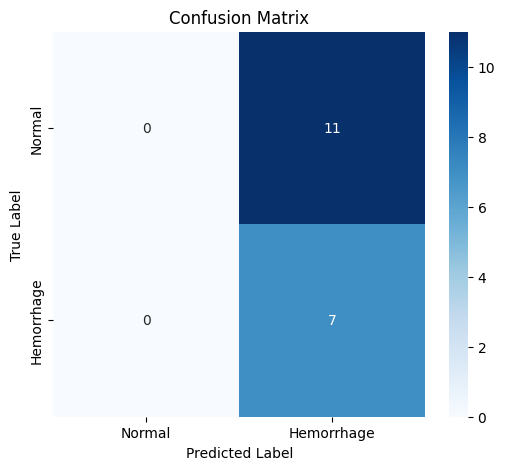

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === Get True & Predicted Labels ===
y_true = y_test
y_pred = (clf_model.predict(X_test) > 0.5).astype(int)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)

# === Plot ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Hemorrhage"], yticklabels=["Normal", "Hemorrhage"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D

def build_efficientnet_classifier(input_shape=(128, 128, 3)):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze base model for transfer learning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)  # binary classification

    model = Model(inputs=base_model.input, outputs=output)
    return model


In [12]:
def load_dicom_image(dcm_path):
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array.astype(np.float32)
    img = cv2.resize(img, (128, 128))
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)

    # Convert grayscale to RGB by stacking
    img = np.stack([img] * 3, axis=-1)  # shape becomes (128,128,3)

    return img


In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = build_efficientnet_classifier()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8)
model.save("classifier_model.h5")
